C:\Users\klyme\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


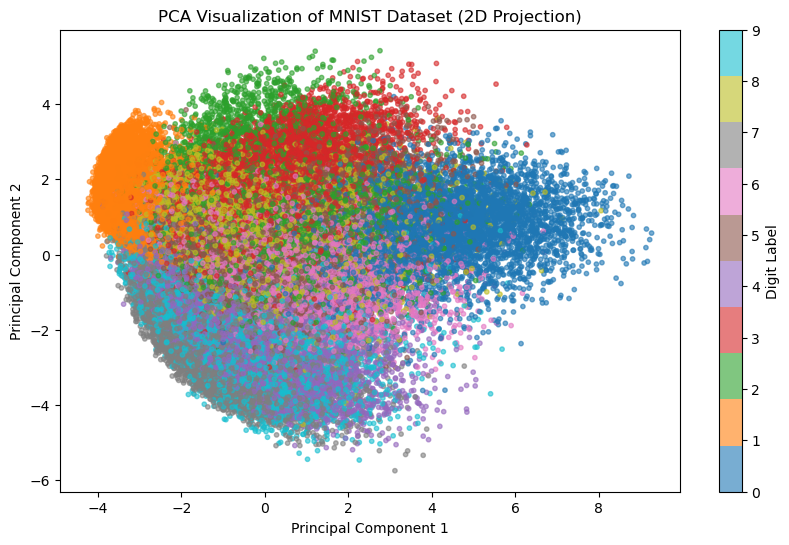

In [1]:
'''
Part 1 Step 1.1
'''

# import necessary libraries
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# set training parameters
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

# define the normalization for the dimensionality reduction technique
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# load the dataset, normalize it, and create dataloaders for the training and testing sets
train_dataset = datasets.MNIST('./mnist_data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./mnist_data/', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

# flatten the data for the PCA dimensionality reduction technique
# and normalize to pixel values between 0 and 1
x_train = train_dataset.data.view(-1, 784).float() / 255.0 
y_train = train_dataset.targets
x_test = test_dataset.data.view(-1, 784).float() / 255.0  
y_test = test_dataset.targets

'''
Reason for PCA over LDA:

I chose PCA for the dimensionality reduction technique as it is able to reduce the dimensions
while still attempting to keep as much information as possible about the data. This ability
to preserve the data will help train the model with better accuracies while reducing noise and 
redundancy with making assumptions about class structure.

LDA on the other hand works by computing matrices, and with the MNIST dataset, this will require
a lot of computational power and can be ineffective for images with lots of data.
'''

# initialize PCA and add it to the dataloaders
pca = PCA(n_components=0.95)
x_train_pca = torch.tensor(pca.fit_transform(x_train), dtype=torch.float32)
x_test_pca = torch.tensor(pca.transform(x_test), dtype=torch.float32)
train_loader_pca = DataLoader(TensorDataset(x_train_pca, y_train), batch_size=batch_size_train, shuffle=True)
test_loader_pca = DataLoader(TensorDataset(x_test_pca, y_test), batch_size=batch_size_test, shuffle=True)

# visualize the results from the PCA technique with a 2D plot
pca_2d = PCA(n_components=2)
x_train_2d = pca_2d.fit_transform(x_train)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_train_2d[:, 0], x_train_2d[:, 1], c=y_train, cmap="tab10", alpha=0.6, s=10)
plt.colorbar(scatter, label="Digit Label")
plt.title("PCA Visualization of MNIST Dataset (2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [2]:
'''
Part 1 Step 1.2
'''

# define a CNN architecture using PyTorch
class CNN(nn.Module):
    def __init__(self, input_dim=None):
        super(CNN, self).__init__()
        self.input_dim = input_dim
        if self.input_dim is None:  
            self.features = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5), #first convolutional layer: 1 input channel, 10 output channels, 5x5 kernel
                nn.ReLU(), # activitation function
                nn.MaxPool2d(2), # 2x2 max pooling to reduce spatial dimensions
                nn.Conv2d(10, 20, kernel_size=5), # second convolutional layer: 10 input channels, 20 output channels, 5x5 kernel
                nn.Dropout2d(), # dropout for regularization to prevent overfitting
                nn.ReLU(), # activitation function
                nn.MaxPool2d(2), # 2x2 max pooling
            )
            self.fc1 = nn.Linear(320, 50) # fully connected layer: 320 input features, 50 output features
        else:  
            self.fc1 = nn.Linear(input_dim, 50) # fully connected layer: input_dim features from PCA, 50 output features
        self.fc2 = nn.Linear(50, 10) # fully connected layer: 50 input features, 10 output features for the ten digits

    def forward(self, x):
        if self.input_dim is None:
            x = self.features(x) 
            x = x.view(-1, 320) # flatten the output for the fully connected layer
        else:
            x = x.view(-1, self.input_dim)
        x = F.relu(self.fc1(x)) # apply ReLU activation on the first fully connected layer
        x = F.dropout(x, training=self.training) # apply dropout during training for regularization
        x = self.fc2(x) # output layer
        return F.log_softmax(x, dim=1) # apply softmax for classification probabilities

# model and optimizer setup
model = CNN()
model_pca = CNN(input_dim=pca.n_components_)
optimizer_pca = optim.SGD(model_pca.parameters(), lr=learning_rate, momentum=momentum)

# training function
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# testing function
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

# train and evaluate the CNN model with the applied PCA dataset
for epoch in range(1, n_epochs + 1):
    train(model_pca, train_loader_pca, optimizer_pca, epoch)
    test(model_pca, test_loader_pca)

'''
Results/Findings:

As shown in the output below, this CNN model using the dataset with which the PCA dimensionality 
reduction technique was applied, achieved an accuracy of 92%. This is a good accuracy for the model 
as it shows that the CNN architecture I used was able to successfully process the data where PCA was 
applied and train it to classify the handwritten digit images.
'''

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.372947
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.341177
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.294352
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.252582
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.278779
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.203547
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.171171
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.142671
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.152910
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.092244
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.078627
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.035009
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.010049
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.992442
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.997478
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.849288
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.925521
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.727535
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.835740
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.693683
Train Epoch: 1 [12800/60000 (

'\nResults/Findings:\n\nAs shown in the output below, this CNN model using the dataset with which the PCA dimensionality \nreduction technique was applied, achieved an accuracy of 92%. This is a good accuracy for the model \nas it shows that the CNN architecture I used was able to successfully process the data where PCA was \napplied and train it to classify the handwritten digit images.\n'


Estimated values:  [0.16468166 0.05842661 0.0435863  0.01412351 0.0197433  0.00604118
 0.01463579 0.02226111 0.05029236 0.02474376]


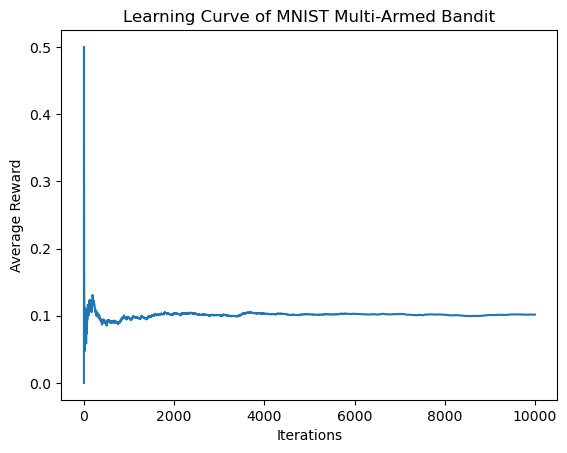

'\nDiscussion on the algorithm\'s effectiveness:\n\nThrough the graph shown below the bandit RL algorithm converges around the 400-500 iteration area \nshowing that it is able to classify the MNIST digit images. Based on the estimated values, where \neach one respectively correlates to one of the ten different arms/digits, the largest value is \nabout 0.1645, meaning it is able to classify the first digit the best. This value shows that is \nhas the best trust in classifying the "0" digit based on its training.\n\nAfter testing with different epsilon values (0.01, 0.1, 0.3, 0.4, and 0.5), the highest estimated \nvalues, meaning higher trust in the action based on the rewards, was with the 0.3 epsilon value.\n'

In [3]:
'''
Part 1 Step 1.3
'''

'''
How to frame the MNIST digit classification as a multi-armed bandit problem:

To correctly frame this dataset for the multi-armed bandit problem, the ten different digit 
classifications can be treated as ten different arms or actions. In this use of this dataset, 
each of the images can be used as the context or state for making the correct decision. For 
this epsilon greedy bandit algorithm can be used to select which digit the image is showing. 
As for the rewards, if the bandit algorithm correctly predicts the digit in the image, some 
positive reward is given. However, if the model is incorrect, a reward of zero is given. There 
is no need for negative rewards as there is no "wrong" choice other than being incorrect...
'''

import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
data = datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)

# define a class named Bandit to model MNIST classification
class MNIST_Bandit:
    # initialize a Bandit object with default parameters for MNIST classification
    def __init__(self, arms=10, epsilon=0.1, alpha=0.1, seed=None):
        self.arms = arms  # 10 possible digits
        self.actions = range(self.arms)
        self.epsilon = epsilon  # exploration rate
        self.alpha = alpha 
        self.total_reward = 0
        self.avg_reward = []  # track average rewards over time
        np.random.seed(seed)  # for reproducibility
        
        # initialize estimated values of each action
        self.values = np.zeros(self.arms)
        self.times = 0  # total actions taken
        self.action_times = np.zeros(self.arms)  # number of times each action was chosen

    # define a method to choose the next action based on epsilon-greedy strategy
    def chooseAction(self):
        # choose exploratin or exploitation
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions) 
        else:
            return np.argmax(self.values)  

    # define method to take an action and update internal state
    def takeAction(self, action, true_label):
        self.times += 1
        self.action_times[action] += 1
        
        # reward is 1 if correct classification, 0 otherwise
        reward = 1 if action == true_label else 0
        
        # update estimated value of the action
        self.values[action] += self.alpha * (reward - self.values[action])
        
        self.total_reward += reward
        self.avg_reward.append(self.total_reward / self.times)

    # define a method to simulate playing the MNIST bandit task for a number of iterations
    def play(self, data, labels, n):
        for i in range(n):
            image, true_label = data[i], labels[i]
            action = self.chooseAction()
            self.takeAction(action, true_label)

if __name__ == "__main__":
    # extract first 10000 images and labels
    images = [data[i][0] for i in range(10000)]
    labels = [data[i][1] for i in range(10000)]

    # initialize Bandit with 10 arms
    bandit = MNIST_Bandit(arms=10, epsilon=0.3, seed=1234)
    bandit.play(images, labels, n=10000)

    # P\print final estimated values
    print("\nEstimated values: ", bandit.values)

    # plot learning curve
    plt.plot(bandit.avg_reward)
    plt.xlabel("Iterations")
    plt.ylabel("Average Reward")
    plt.title("Learning Curve of MNIST Multi-Armed Bandit")
    plt.show()

'''
Discussion on the algorithm's effectiveness:

Through the graph shown below the bandit RL algorithm converges around the 400-500 iteration area 
showing that it is able to classify the MNIST digit images. Based on the estimated values, where 
each one respectively correlates to one of the ten different arms/digits, the largest value is 
about 0.1647, meaning it is able to classify the first digit the best. This value shows that is 
has the best trust in classifying the "0" digit based on its training.

After testing with different epsilon values (0.01, 0.1, 0.3, 0.4, and 0.5), the highest estimated 
values, meaning higher trust in the action based on the rewards, was with the 0.3 epsilon value.
'''

In [4]:
'''
Part 1 Step 2.1
'''

'''
Going with an original CNN approach, it's very effective at classifying the MNIST dataset as 
it is generally used for images. However, compared to some other models it is quite expensive 
in terms of computation and even harder to understand when going with data that is complex 
and hard to understand.

Now, like my CNN model in this file, applying the PCA dimensionality reduction technique on the 
MNIST data will greatly improve the efficiency, and computation costs (time), and will have a much 
quicker convergence time as I've figured out the hard way. However, due to reducing the dimensions 
of the data, some relationships/patterns may not be captured.

For the RL bandit approach, it was the quickest algorithm to run and is probably also the simplest 
and worked decently well for this MNIST task. However, through the results from step 1, I do not 
think that it is good at classifying image datasets.

Therefore, I believe that the CNN model I defined and used for classifying the MNIST dataset is the 
best. 
'''

'''
Part 1 Step 2.2
'''

'''
I believe that preferred scenarios for the CNN model are when there are large and complex datasets 
with potentially hard to understand relationships. CNN is a great model as it can handle large 
datasets, like images, effectively and with high performance. However, the limitation of this model 
is that firstly it has high computational costs and requires lots of time and power for training 
and predictions, especially with datasets that are in the millions. Another limitation of CNNs is 
the fact that the model requires to have millions of entries in the dataset in order to achieve 
performance. Only having a few thousand will not be very useful.

For the bandit RL approach, the preferred scenario would be when working with simpler data that does 
not have a complex structure (unlike CNN). As shown in this file, the bandit approach to classifying 
the MNIST dataset was much quicker than the CNN model. It also has lower computation costs. It also 
is very good at making decisions through its ability to explore and exploit. It can 
try different strategies and learn through rewards (similarly to how humans learn in real life). 
However, its limitations are that it cannot process complex data like the CNN model and it is 
not the best at learning meaning features from the dataset.
'''

'\nI believe that preferred scenarios for the CNN model are when there are large and complex datasets \nwith potentially hard to understand relationships. CNN is a great model as it can handle large \ndatasets, like images, effectively and with high performance. However, the limitation of this model \nis that firstly it has high computational costs and requires lots of time and power for training \nand predictions, especially with datasets that are in the millions. Another limitation of CNNs is \nthe fact that the model requires to have millions of entries in the dataset in order to achieve \nperformance. Only having a few thousand will not be very useful.\n\nFor the bandit RL approach, the preferred scenario would be when working with simpler data that does \nnot have a complex structure (unlike CNN). As shown in this file, the bandit approach to classifying \nthe MNIST dataset was much quicker than the CNN model. It also has lower computation costs. It also \nis very good at making d

In [13]:
'''
Part 1 Step 3.1
'''

# set new training parameters
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

# define a CNN architecture using PyTorch
class CNN(nn.Module):
    def __init__(self, input_dim=None):
        super(CNN, self).__init__()
        self.input_dim = input_dim
        if self.input_dim is None:  
            self.features = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3), 
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, kernel_size=3), 
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(64, 128, kernel_size=3), 
                nn.ReLU(),
                nn.MaxPool2d(2),
            )
            self.fc1 = nn.Linear(320, 50) # fully connected layer: 320 input features, 50 output features
        else:  
            self.fc1 = nn.Linear(input_dim, 50) # fully connected layer: input_dim features from PCA, 50 output features
        self.fc2 = nn.Linear(50, 10) # fully connected layer: 50 input features, 10 output features for the ten digits

    def forward(self, x):
        if self.input_dim is None:
            x = self.features(x) 
            x = x.view(-1, 320) # flatten the output for the fully connected layer
        else:
            x = x.view(-1, self.input_dim)
        x = F.relu(self.fc1(x)) # apply ReLU activation on the first fully connected layer
        x = F.dropout(x, training=self.training) # apply dropout during training for regularization
        x = self.fc2(x) # output layer
        return F.log_softmax(x, dim=1) # apply softmax for classification probabilities

# model and optimizer setup
model = CNN()
model_pca = CNN(input_dim=pca.n_components_)
optimizer_pca = optim.SGD(model_pca.parameters(), lr=learning_rate, momentum=momentum)

# train and evaluate the CNN model with the applied PCA dataset
for epoch in range(1, n_epochs + 1):
    train(model_pca, train_loader_pca, optimizer_pca, epoch)
    test(model_pca, test_loader_pca)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319300
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.267635
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.241877
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.262220
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.225416
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.170453
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.191558
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.159653
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.060411
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.979772
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.054003
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.956616
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.946215
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.943415
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.910483
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.829520
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.770969
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.744473
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.547104
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.660459
Train Epoch: 1 [12800/60000 (

In [ ]:
'''
Part 1 Step 3.2
'''

'''
Through the code shown in the above code block, this adjusted CNN architecture and hyperparameters 
were able to achieve a higher accuracy score of 94% (the old accuracy was 92%). For this model, I 
added a third convolutional layer that could give CNN a better ability to learn from complex 
data. I believe this allows the model to generalize the MNIST dataset better. I also increased the 
number of filters from 10 and 20 to 32, 64, and 128. This increase in filters allows the model to 
learn more complex patterns. I also adjust the kernel size to be smaller which I remember does this  
can allow the CNN to process data better.
'''